# Transform bounding box to instance mask annotations using Segment Anything Model

[![Jupyter Notebook](https://img.shields.io/badge/jupyter-%23FA0F00.svg?style=for-the-badge&logo=jupyter&logoColor=white)](https://github.com/openvinotoolkit/datumaro/blob/develop/notebooks/18_bbox_to_instance_mask_using_sam.ipynb)

This tutorial covers how to convert bounding box annotations to instance mask annotations using [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything).
This feature requires a dedicated model inference server instance.
We provide how to build the Docker image of model inference server for SAM in [this guide](https://github.com/openvinotoolkit/datumaro/blob/develop/docker/segment-anything/README.md).
Please build the Docker image first before you follow this tutorial.
We will use the `vit_b` SAM model deployed on [OpenVINO™ Model Server](https://github.com/openvinotoolkit/model_server) instance, thus you need to build `segment-anything-ovms:vit_b` Docker image in preperation.
However, the other SAM model types (`vit_l` and `vit_h`) are avaialbe as well.

## Prerequisite
### Download Six-sided Dice dataset
This is [a download link for Six-sided Dice dataset in Kaggle](https://www.kaggle.com/datasets/nellbyler/d6-dice?resource=download). Please download using this link and extract to your workspace directory. Then, you will have a `d6-dice` directory with annotations and images in YOLO format as follows.

```bash
d6-dice
├── Annotations
│   ├── classes.txt
│   ├── IMG_20191208_111228.txt
│   ├── IMG_20191208_111246.txt
│   ├── ...
└── Images
    ├── IMG_20191208_111228.jpg
    ├── IMG_20191208_111246.jpg
    ├── ...
```

However, for import compatibility, `obj.names` file must be added to `d6-dice/obj.names` filepath for import compatibility. This `obj.names` file includes the label names of the dataset, e.g., `[dice1, ..., dice6]`. Therefore, you can write it with the following simple code. Please see [Yolo Loose format](https://openvinotoolkit.github.io/datumaro/latest/docs/explanation/formats/yolo) for more details.

In [ ]:
# Copyright (C) 2023 Intel Corporation
#
# SPDX-License-Identifier: MIT

import os

root_dir = "d6-dice"

names = """
dice1
dice2
dice3
dice4
dice5
dice6
"""

fpath = os.path.join(root_dir, "obj.names")
with open(fpath, "w") as fp:
    fp.write(names)

### Launch the Model Inference Server for SAM
In this tutorial, we will launch an instance of the OpenVINO™ Model Server to serve the SAM encoder and decoder models on your local machine.
Alternatively, you can opt for the NVIDIA Triton™ Inference Server as well.
For additional information, please refer to [this guide](https://github.com/openvinotoolkit/datumaro/blob/develop/docker/segment-anything/README.md).

To launch the OpenVINO™ Model Server instance and expose the gRPC endpoint on `localhost:8001`, use the following `docker run` command:

In [ ]:
!docker run -d --rm --name ovms_sam -p 8001:8001 segment-anything-ovms:vit_b --port 8001

## Transfrom bounding box to instance mask annotations

We first import `d6-dice` dataset using Datumaro.
Because it is the object detection task dataset, the original dataset has only bounding box annotations.
We can convert the bounding box annotations to instance mask annotations using the SAM model.
Datumaro provides this annotation transformation feature as follows.

In [ ]:
import datumaro as dm

dataset = dm.Dataset.import_from("d6-dice", format="yolo")
dataset

As we imagined, there are bounding box annotations in the dataset as follows.

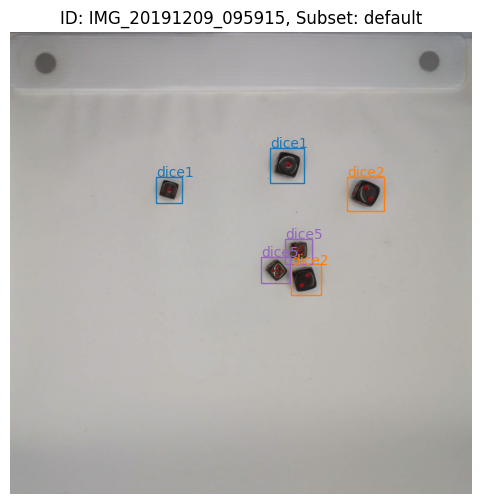

In [2]:
item_id = "IMG_20191209_095915"
subset = "default"

viz = dm.Visualizer(dataset, figsize=(8, 6))
fig = viz.vis_one_sample(item_id, subset)
fig.show()

Now, we apply `SAMBboxToInstanceMask` to the dataset. This transform requires several arguments to execute properly.

`inference_server_type` represents the type of inference server on which SAM encoder and decoder are deployed. In this example, we launched the OpenVINO™ Model Server instance. Therefore, please select `InferenceServerType.ovms`.

The gRPC endpoint address was `localhost:8001`. To configure this, provide the following parameters:
- `host="localhost"`
- `port=8001`
- `protocol_type=ProtocolType.grpc`

You can also specify a `timeout=60.0` value, which represents the maximum seconds to wait for a response from the server instance.

Additionally, you can choose to produce `Polygon` output for the instance mask. However, in this case, we have set `to_polygon` to `False`, resulting in an output of the `Mask` annotation type.

Lastly, we've set `num_workers=0`. This means we will use synchronous iteration to send a model inference request to the server instance and wait for the inference results. If you need to handle multiple inference requests concurrently, you can increase this value to utilize a thread pool. This is particularly useful when dealing with server instances that have high throughput.

In [3]:
from datumaro.plugins.sam_transforms import SAMBboxToInstanceMask
from datumaro.plugins.inference_server_plugin import InferenceServerType, ProtocolType

with dm.eager_mode():
    dataset.transform(
        SAMBboxToInstanceMask,
        inference_server_type=InferenceServerType.ovms,
        host="localhost",
        port=8001,
        timeout=60.0,
        protocol_type=ProtocolType.grpc,
        to_polygon=False,
        num_workers=0,
    )

Let's visualize the transformed dataset again.
In the following figure, you can see that the bounding box annotations are converted to the instance mask.

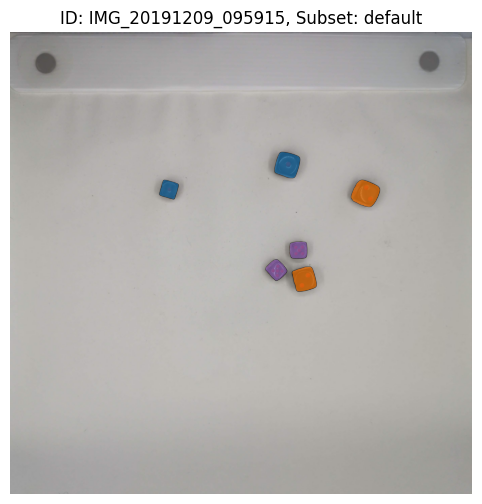

In [4]:
viz = dm.Visualizer(dataset, figsize=(8, 6), alpha=0.7)
fig = viz.vis_one_sample(item_id, subset)
fig.show()

If you want to convert Mask annotation to Polygon even after the `SAMBboxToInstanceMask` with `to_polygon=False`, you can transform your dataset again using `MasksToPolygons` transform provided by Datumaro.

In [5]:
from datumaro.plugins.transforms import MasksToPolygons

print("Before MaskToPolygons transform")
for ann in dataset.get(item_id, subset).annotations[:2]:
    print(ann)

with dm.eager_mode():
    dataset.transform(MasksToPolygons)

print("After MaskToPolygons transform")
for ann in dataset.get(item_id, subset).annotations[:2]:
    print(ann)

Before MaskToPolygons transform
Mask(id=0, attributes={}, group=0, object_id=-1, _image=array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), label=0, z_order=0)
Mask(id=1, attributes={}, group=1, object_id=-1, _image=array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), label=0, z_order=0)
After MaskToPolygons transform
Polygon(id=0, attributes={}, group=0, object_id=-1, points=[912.0, 876.0, 909.0, 878.

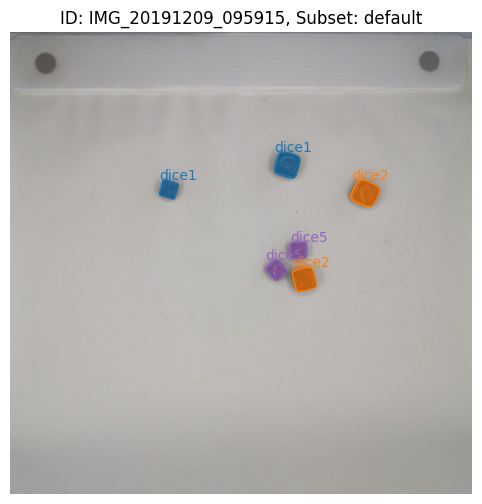

In [6]:
viz = dm.Visualizer(dataset, figsize=(8, 6), alpha=0.7)
fig = viz.vis_one_sample(item_id, subset)
fig.show()

Consequently, we export this dataset to the COCO format as follow.

In [8]:
dataset.export("d6-dice-inst-mask", format="coco_instances", save_media=True)